# Imports

In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Checking GPU

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Display Datasets

In [3]:
# from dataset import number_of_images
# # from IPython.display import display

# train_data = "data/train/"
# test_data = "data/test/"

# number_of_images(train_data, "train")
# number_of_images(test_data, "test")

## Creating the Datasets

Define paramters for the data loaders

In [4]:
batch_size = 64
img_height = 48
img_width = 48
color_mode = 'rgb'
validation_split = 0.25

train_data = "data/CK+/train/"
test_data = "data/CK+/test/"

Load the data into the datasets

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    color_mode = color_mode,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    color_mode = color_mode,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 720 files belonging to 7 classes.
Using 540 files for training.
Found 720 files belonging to 7 classes.
Using 180 files for validation.
Found 182 files belonging to 7 classes.


View the classes in the dataset

In [6]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


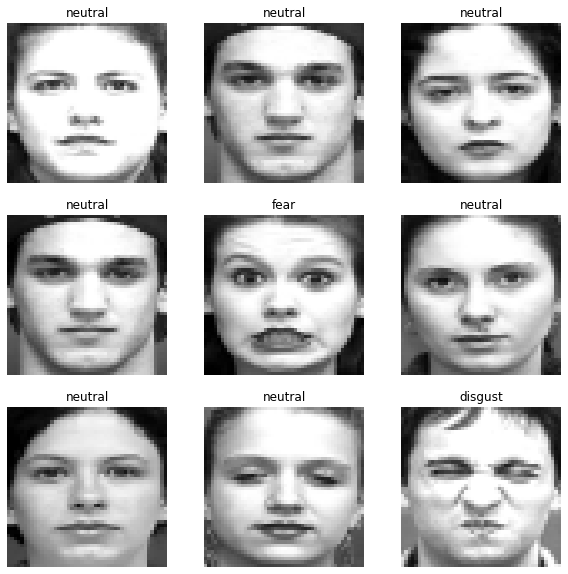

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configuring the Datset
Enable buffered prefetching so you can yield data from disk without having I/O become blocking

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating the Model

In [9]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1

## Train the Model

In [12]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
9/9 [==============================] - 2s 40ms/step - loss: 1.3716 - accuracy: 0.6241 - val_loss: 1.2858 - val_accuracy: 0.6667
Epoch 2/50
9/9 [==============================] - 0s 8ms/step - loss: 1.2718 - accuracy: 0.6556 - val_loss: 1.2235 - val_accuracy: 0.6667
Epoch 3/50
9/9 [==============================] - 0s 8ms/step - loss: 1.2444 - accuracy: 0.6556 - val_loss: 1.2276 - val_accuracy: 0.6667
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 1.2187 - accuracy: 0.6556 - val_loss: 1.2070 - val_accuracy: 0.6667
Epoch 5/50
9/9 [==============================] - 0s 8ms/step - loss: 1.1639 - accuracy: 0.6556 - val_loss: 1.1654 - val_accuracy: 0.6667
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 1.1026 - accuracy: 0.6574 - val_loss: 1.0773 - val_accuracy: 0.6722
Epoch 7/50
9/9 [==============================] - 0s 8ms/step - loss: 0.9723 - accuracy: 0.7130 - val_loss: 0.9657 - val_accuracy: 0.7611
Epoch 8/50
9/9 [=================

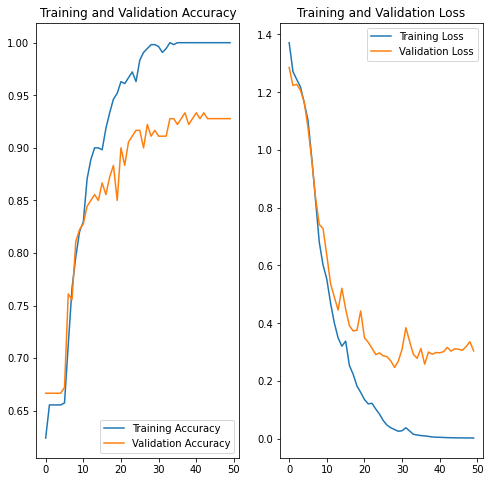

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data Augmentation

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [15]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 48, 48, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                  

In [18]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
9/9 [==============================] - 1s 22ms/step - loss: 1.4582 - accuracy: 0.5889 - val_loss: 1.2950 - val_accuracy: 0.6667
Epoch 2/100
9/9 [==============================] - 0s 12ms/step - loss: 1.2935 - accuracy: 0.6556 - val_loss: 1.2657 - val_accuracy: 0.6667
Epoch 3/100
9/9 [==============================] - 0s 12ms/step - loss: 1.2595 - accuracy: 0.6556 - val_loss: 1.2385 - val_accuracy: 0.6667
Epoch 4/100
9/9 [==============================] - 0s 14ms/step - loss: 1.2549 - accuracy: 0.6556 - val_loss: 1.2452 - val_accuracy: 0.6667
Epoch 5/100
9/9 [==============================] - 0s 11ms/step - loss: 1.2396 - accuracy: 0.6556 - val_loss: 1.2312 - val_accuracy: 0.6667
Epoch 6/100
9/9 [==============================] - 0s 11ms/step - loss: 1.2481 - accuracy: 0.6556 - val_loss: 1.2391 - val_accuracy: 0.6667
Epoch 7/100
9/9 [==============================] - 0s 11ms/step - loss: 1.2476 - accuracy: 0.6556 - val_loss: 1.2386 - val_accuracy: 0.6667
Epoch 8/100
9/9 [===

9/9 [==============================] - 0s 11ms/step - loss: 0.2885 - accuracy: 0.9037 - val_loss: 0.3726 - val_accuracy: 0.9056
Epoch 60/100
9/9 [==============================] - 0s 10ms/step - loss: 0.3113 - accuracy: 0.9037 - val_loss: 0.3861 - val_accuracy: 0.9111
Epoch 61/100
9/9 [==============================] - 0s 11ms/step - loss: 0.2760 - accuracy: 0.9074 - val_loss: 0.3476 - val_accuracy: 0.9111
Epoch 62/100
9/9 [==============================] - 0s 10ms/step - loss: 0.2404 - accuracy: 0.9204 - val_loss: 0.3013 - val_accuracy: 0.9056
Epoch 63/100
9/9 [==============================] - 0s 11ms/step - loss: 0.2275 - accuracy: 0.9204 - val_loss: 0.3572 - val_accuracy: 0.8944
Epoch 64/100
9/9 [==============================] - 0s 13ms/step - loss: 0.3021 - accuracy: 0.9019 - val_loss: 0.4516 - val_accuracy: 0.8833
Epoch 65/100
9/9 [==============================] - 0s 11ms/step - loss: 0.2802 - accuracy: 0.9093 - val_loss: 0.3998 - val_accuracy: 0.9000
Epoch 66/100
9/9 [========

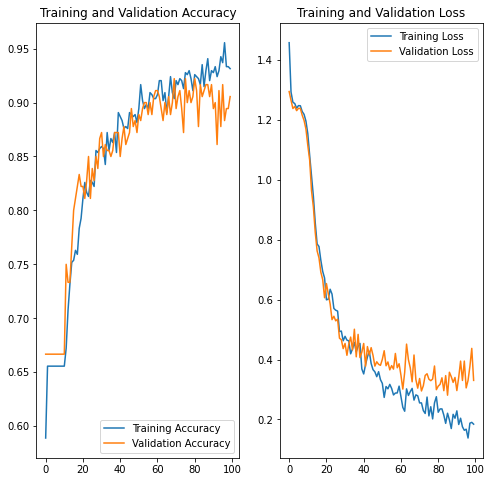

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
print("Evaluate")
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

Evaluate
3/3 [==============================] - 0s 17ms/step - loss: 0.5669 - accuracy: 0.8846


{'loss': 0.5669105648994446, 'accuracy': 0.8846153616905212}